# Статистика, DS-поток
## Практическое задание 6. Экспоненциальный класс распределений

In [26]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import combinations

%matplotlib inline

sns.set(font_scale=1.5, style='whitegrid', palette='plasma')

In [3]:
alpha = 0.95

______________
## Задача 1.
В этой задаче нужно сделать оценку максимального правдоподобия для многомерного нормального распределения по датасету химимического анализа вин трех разных сортов в Италии.
Скачайте данные по ссылке https://archive.ics.uci.edu/ml/datasets/wine (файл `wine.data`) и загрузите их с помощью библиотеки pandas.

In [5]:
data_wine = pd.read_csv('./wine.data', header=None, names=[
    'Class', 'Alcohol', 'Malic acid','Ash', 'Alcalinity of ash', 'Magnesium', 'Total phenols','Flavanoids', 
    'Nonflavanoid phenols','Proanthocyanins', 'Color intensity','Hue', 'OD280/OD315 of diluted wines',
    'Proline'
])

Пусть выборка $X = (X_1, ..., X_n)$ такова, что каждый ее элемент имеет многомерное нормальное распределение со средним вектором $a \in \mathbb {R} ^d$ и матрицей ковариаций $\Sigma \in \mathbb {R} ^ {d \times d}$.

Запишите оценку максимального правдоподобия для параметров $a$ и $\Sigma$.

**Ответ:** 

$$\widehat{a} = \overline{X}$$
$$\widehat{\Sigma} = \frac{1}{n}\sum\limits_{i=1}^n(X_i - \widehat{a})(X_i-\widehat{a})^\top$$

Рассмотрим колонки "Alcalinity of ash", "Nonflavanoid phenols", "Proanthocyanins", "Hue" для всех сортов вина вместе.
Предположим, что данные в них образуют выборку из многомерного нормального распределения с неизвестными параметрами, которые вам нужно оценить.

Визуализируйте рассматриваемые данные с помощью `seaborn.pairplot`, чтобы убедиться в том, что данные визуально похожи на нормальное распределение:

In [7]:
features_of_int = ['Alcalinity of ash', 'Nonflavanoid phenols', 'Proanthocyanins', 'Hue']
data_wine = data_wine[features_of_int]

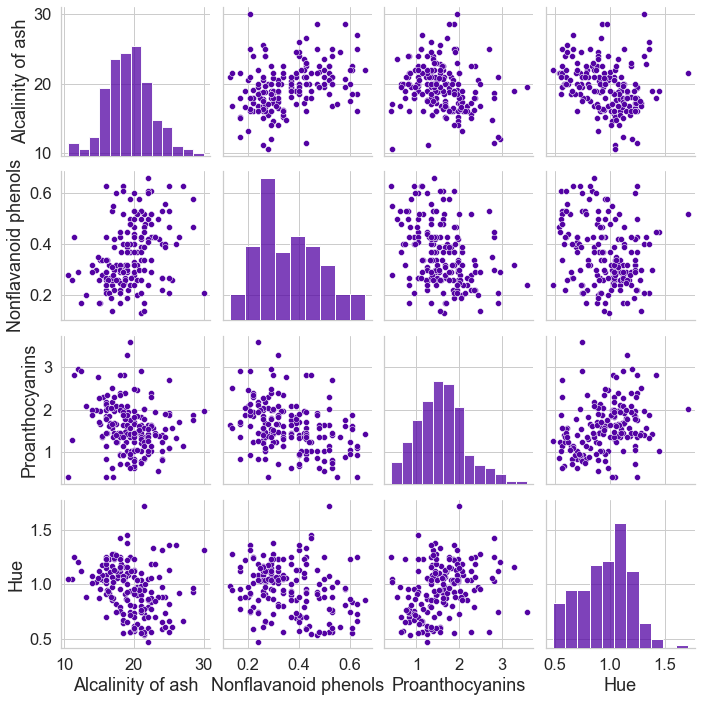

In [10]:
sns.pairplot(data_wine);

Напишите функцию подсчета оценки максимального правдоподобия для вектора средних $a$ и матрицы ковариаций $\Sigma$ по выборке. Использование циклов наказуемо.

In [25]:
def mle_for_mean(sample):
    '''
    :param sample: выборка из многомерного нормального распределения
    :return: ОМП для вектора средних
    '''
    
    return sample.mean(axis=0)

In [36]:
def mle_for_covariance_matrix(sample):
    '''
    :param sample: выборка из многомерного нормального распределения
    :return: ОМП для матрицы ковариаций
    '''
    n = len(sample)
    mean = sample.mean(axis=0)
    X = sample - mean
    return (1/n)*(X.T @ X)

In [42]:
means = mle_for_mean(data_wine.values)
sigmas = mle_for_covariance_matrix(data_wine.values)

Визуализируйте полученный результат. Для каждой пары признаков постройте информативный график, на котором будут:

1. Точки выборки.

2. Плотность нормального распределения с оцененными параметрами, которую изобразите в виде линий уровня.

**hint:** используйте функции `plt.pcolormesh` и `plt.clabel`

In [183]:
def draw_features(sample, distribution, labels):
    '''
    Функция для изображения зависимости пары признаков с плотностью распределения, 
    построенного по их ОМП среднего и дисперсии
    '''
    grid_lims = np.array([sample.min(axis=0).values, sample.max(axis=0).values]).T
    xs, ys = np.meshgrid(np.linspace(*grid_lims[0], 100), np.linspace(*grid_lims[1], 100))
    density = distribution.pdf(np.dstack((xs, ys)))
    
    plt.figure(figsize=(18, 8))
    
    # наносим плотность нормального распределения в виде линий уровня
    plt.pcolormesh(xs, ys, density, cmap='jet', shading='auto')
    clevels = plt.contour(xs, ys, density)
    plt.clabel(clevels)
    
    # наносим выборка
    plt.scatter(*sample.values.T, label='Выборка', c='w', alpha=0.7)

    plt.title(f'Зависимость {labels[1]} от {labels[0]}')
    plt.xlabel(labels[0])
    plt.ylabel(labels[1])
    plt.legend()

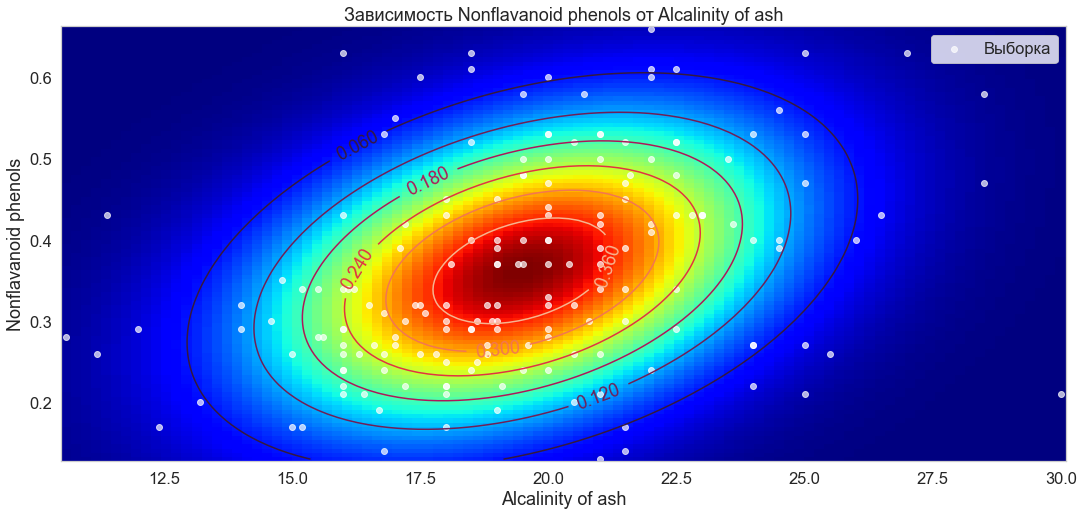

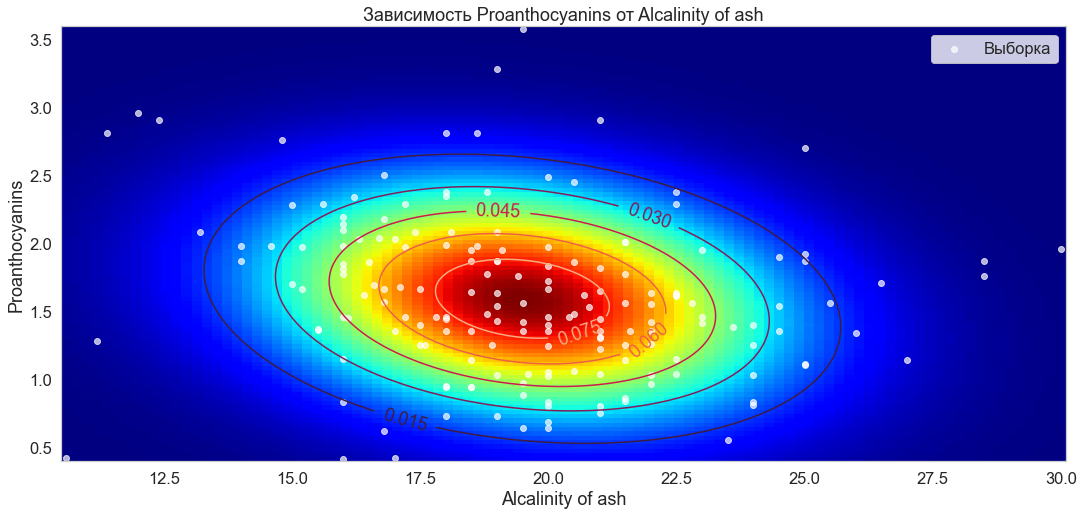

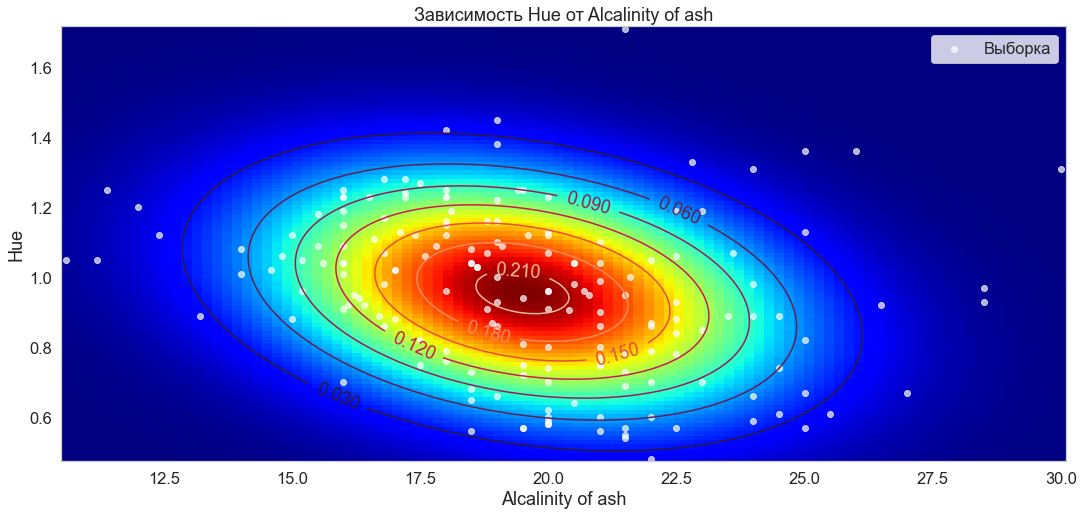

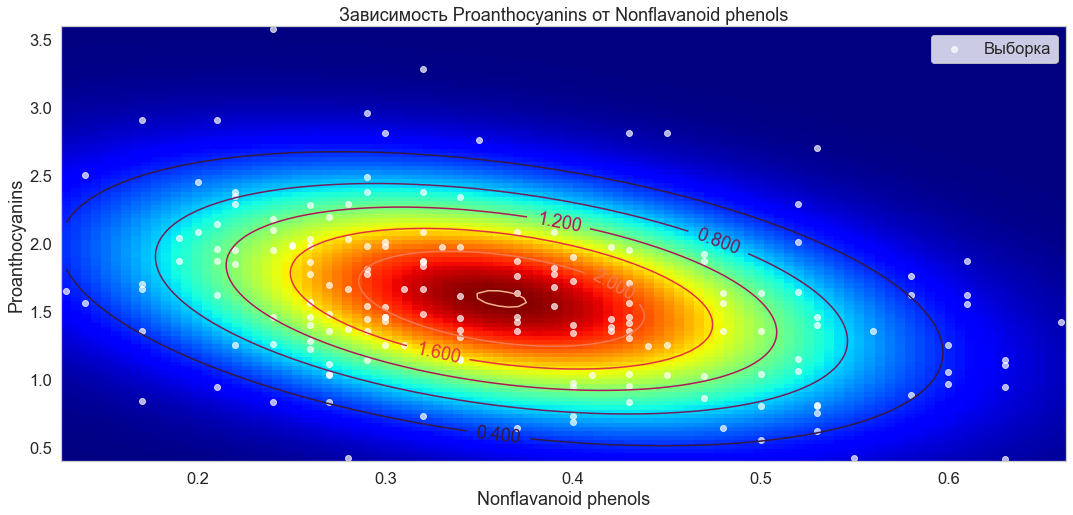

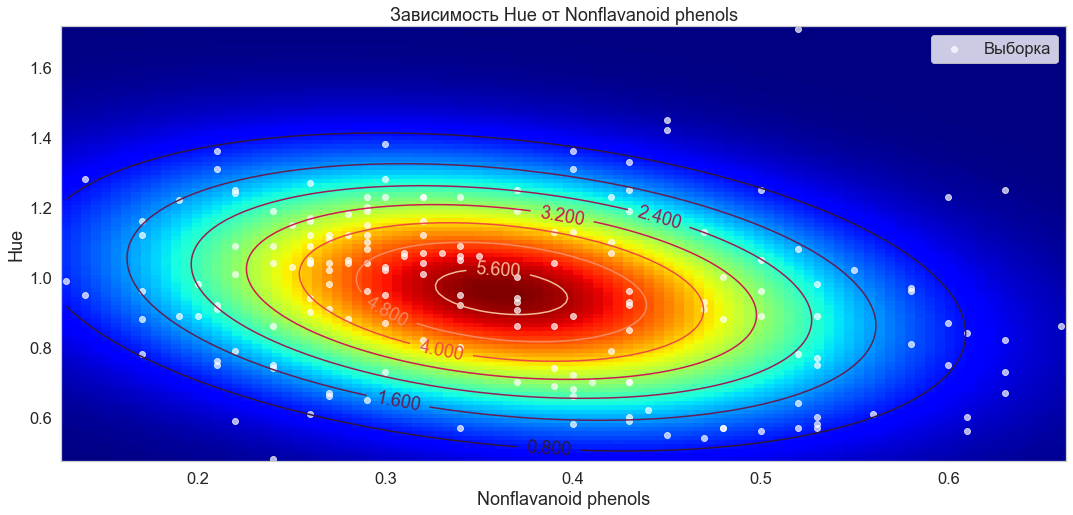

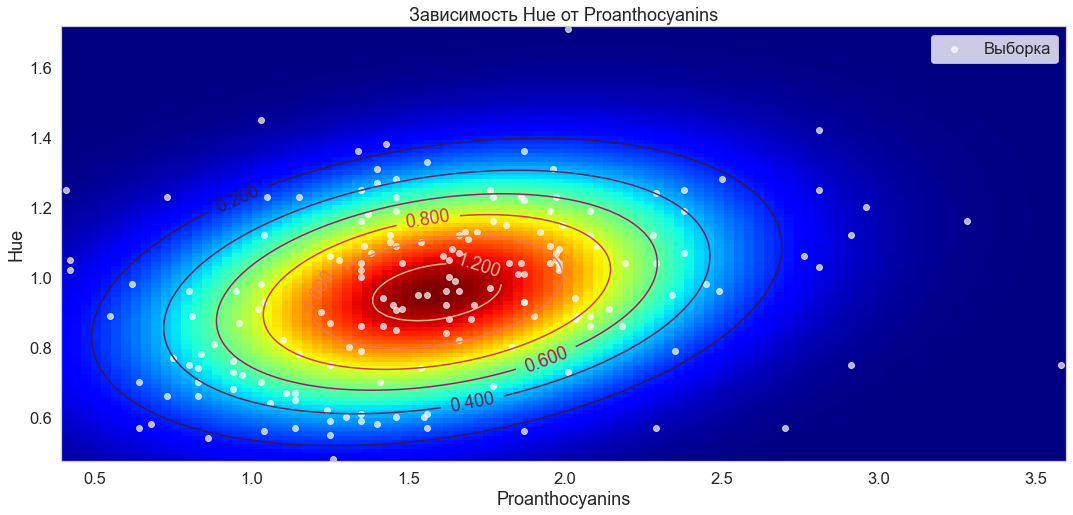

In [202]:
feature_pairs = list(combinations(range(4), 2))

for pair in feature_pairs:
    subsample = data_wine.iloc[:, list(pair)]
    i, j = pair[0], pair[1]
    mean = [means[i], means[j]]
    cov = [[sigmas[i][i], sigmas[i][j]], [sigmas[j][i], sigmas[j][j]]]
    dist = sps.multivariate_normal(mean=mean, cov=cov)
    labels = [data_wine.columns[i], data_wine.columns[j]]

    draw_features(subsample, dist, labels)

**Вывод:** *Так как мы генерируем двумерное нормальное распределение, основное количество точек выборки должно попадать в середину "холма" и уменьшаться с увеличением расстояния от центра, что и подтверждается глядя на графики. Значит, предположение о нормальности распределения признаков в данном эксперименте подтверждается.*

__________________
## Задача 2.

**1.** Загрузите с помощью `pandas` из файла `airquality.csv` данные о качестве воздуха в Нью-Йорке с мая по сентябрь 1973 года по дням. Данные содержат измерения нескольких величин, описания которых можно прочитать [по ссылке](https://www.rdocumentation.org/packages/datasets/versions/3.5.1/topics/airquality).

In [167]:
data_airquaity = pd.read_csv('airquality.csv')

Выведите описательные статистики (метод `describe`) для всех признаков, для которых это имеет смысл.  Округлите до второго знака после запятой.

In [173]:
round(data_airquaity.describe(), 2)

,Ozone,Solar.R,Wind,Temp,Month,Day
count,116.00,146.00,153.00,153.00,153.00,153.00
mean,42.13,185.93,9.96,77.88,6.99,15.80
std,32.99,90.06,3.52,9.47,1.42,8.86
min,1.00,7.00,1.70,56.00,5.00,1.00
25%,18.00,115.75,7.40,72.00,6.00,8.00
50%,31.50,205.00,9.70,79.00,7.00,16.00
75%,63.25,258.75,11.50,85.00,8.00,23.00
max,168.00,334.00,20.70,97.00,9.00,31.00


Что можно сказать о наличии в данных выбросов, сравнивая выборочную медиану и выборочное среднее?

**Ответ:** *Медиана - это 50-процентиль. Выбросы сильно влияют на среднее, но не на медиану. Сильное отличие среднего от медианы говорит, что в данных присутсвуют выбросы. Скорее всего, выбросы есть в `Ozon`, `Solar.R`*

**2.** Теперь для каждого параметра постройте график ящиков с усами (`boxplot`), в котором ось `x` соответствует номеру месяца, а ось `y` — значениям параметра (т.е. свой ящик для каждого месяца). Используйте функцию `seaborn.boxplot`.

In [187]:
features = data_airquaity.columns

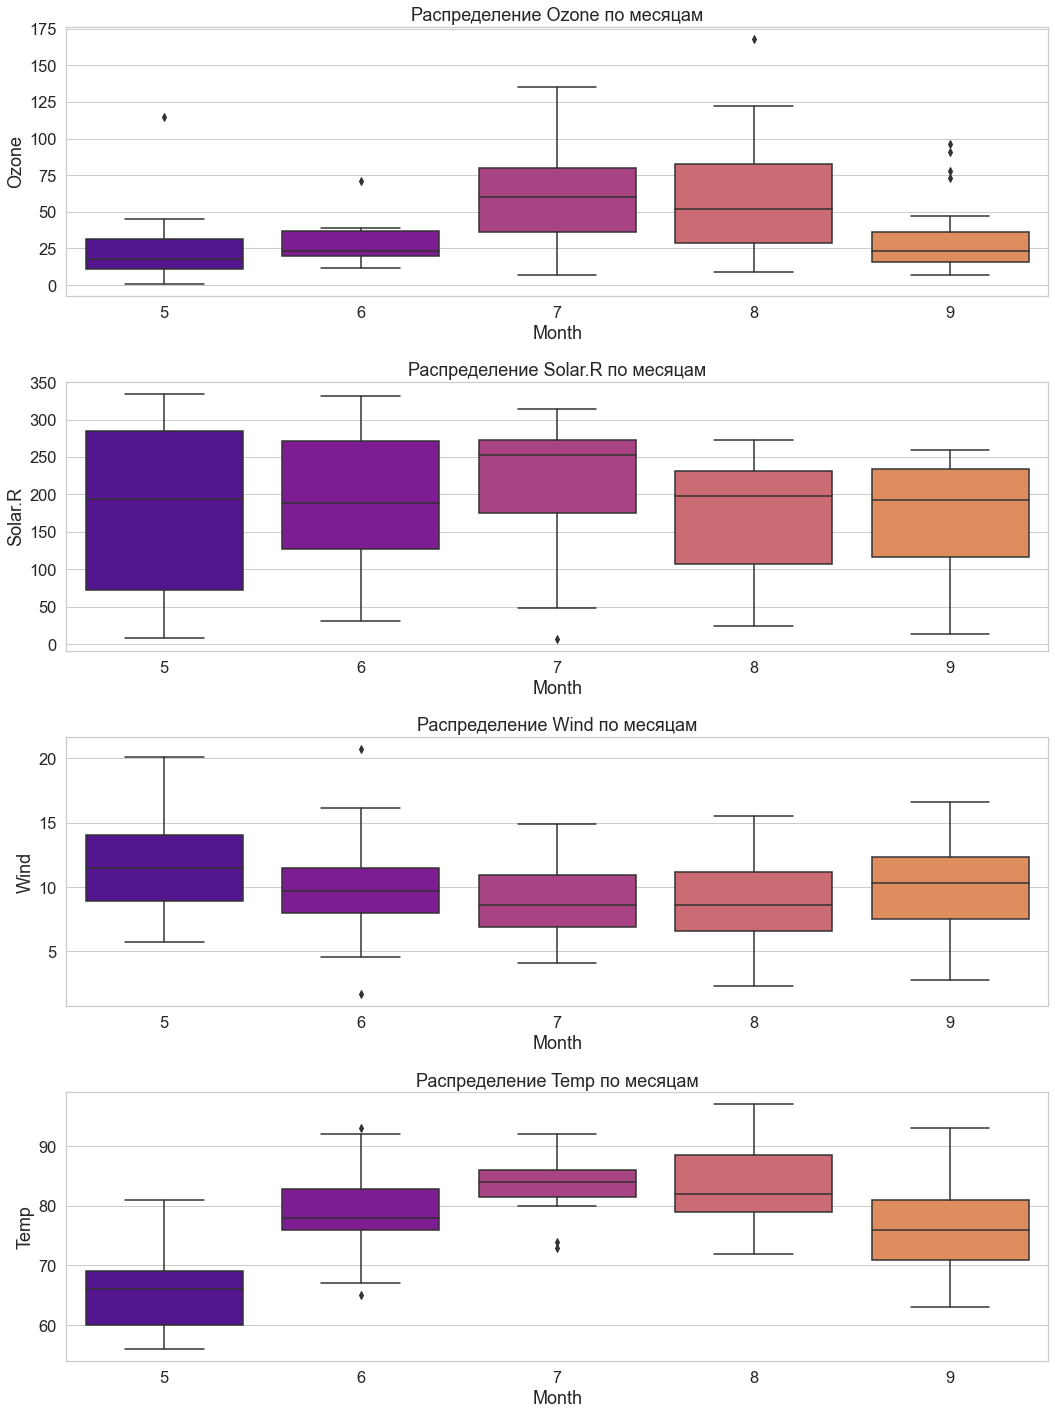

In [194]:
fig, axs = plt.subplots(4, figsize=(15, 20))
      
for i in range(4):
    sns.boxplot(x='Month', y=features[i], data=data_airquaity, ax=axs[i])
    axs[i].set_title(f'Распределение {features[i]} по месяцам')
plt.tight_layout()

Опишите структуру `boxplot`. Какие выводы можно сделать в данном случае?

**Ответ:** *Границами ящика служат первый и третий квартили (25-й и 75-й процентили соответственно), линия в середине ящика — медиана (50-й процентиль). Концы усов - минимальное и максимальное значения, внешние точки - выбросы.*
*По графикам можно сделать вывод, какие есть выбросы в каждом признаке. Наибольшее количество выбросов - у признака `Ozone`. Также у каждого можно наблюдать изменение разброса значений по месяцам. Например, самый небольшой - у признака `Wind`.*

**3.** Для параметра с наибольшим числом наблюдений, признанных выбросами, посчитайте и сравните: 
- выборочное среднее; 
- выборочную медиану;
- медиану средних Уолша.

Для реализации медианы средних Уолша без циклов обратите внимание на следующие **подсказки**:
1. Что будет, если вы сложите вектор-строку и вектор столбец одинакового размера?
2. Если вы правильно ответите на прошлый вопрос, вам пригодится `np.triu_indices_from`.

In [429]:
feature = data_airquaity.Ozone.dropna()

n = feature.shape[0]

In [441]:
mean = feature.mean()
median = np.median(feature)

In [436]:
avgs = (feature.values + feature.values.reshape((n, 1))) / 2
walsh_averages = avgs[np.triu_indices(n, k=1)]
walsh_averages_median = np.median(walsh_averages)

In [447]:
print(f'Среднее: {np.round(mean, 1)}')
print(f'Медиана: {median}')
print(f'Медиана средних Уолша: {walsh_averages_median}')      

Среднее: 42.1
Медиана: 31.5
Медиана средних Уолша: 38.5


Какими свойствами статистик вызваны наблюдаемые различия?

**Ответ:** *Медиана не подвержена выбросам, а вот среднее довольно сильно подвержено, поэтому оно имеет наибольшее значение. Медиана средних Уолша - робастная оценка, поэтому она меньше подвержена влиянию выбросов, чем среднее, и поэтому она ближе к медиане*

При подсчете этих статистик обычно предполагается, что наблюдения независимы. Выполнено ли это свойство в данном случае?

**Ответ:** *Мы анализируем **в предположении** что наблюдения независимы. У нас нет отдельной информации про это*

А оно часто бывает выполнено? Как это можно проверить? Что бывает, когда оно нарушается? Какие вы есть количественные меры зависимости между признаками? Ответы на эти вопросы вы узнаете в весеннем семестре, но задуматься и порассуждать полезно уже сейчас.

*В реальности наблюдения могут быть зависимы. Например, независимость значений экспериментов может нарушиться из-за поломки прибора. Независимость означает, что на отдельное значение не влияет значение любого другого наблюдения в наборе. Независимые наблюдения не коррелированы, но обратное неверно — отсутствие корреляции не обязательно означает независимость. Если независимость нарушена, набор наблюдений вообще нельзя считать выборкой (нарушается определение), а значит все дальнейшие рассуждения о распределении признака не будут верны.*

Сделайте выводы о полезности робастных статистик, методах визуального анализа и о наличии независимых одинаково распределённых случайных величин в реальном мире.

**Вывод:** *Наличие в выборке даже небольшого количества выбросов может сильно повлиять повлиять на статистику, и значения, получаемые в результате исследования, могут перестать нести в себе какой-либо смысл. Для исключения влияния таких помех применяют в том числе робастные статистики, которые слабо зависят от выбросов.*

*Также статистические методы перестают иметь смысл, если нарушается условие независимости элементов выборки. Хотя в реальном мире невозможно утверждать, что случайные величины полностью независимы, все равно важно проверять выборку на независимость.*

______________
## Задача 3.
Предлагается изучить некоторые свойства распределения Коши с параметром сдвига $\theta$, обладающего плотностью распределения $p_{\theta}(x) = \frac{1}{\pi \left(1 + \left(x- \theta\right)^2\right)}$.

*Замечание:* Такое распределение встречается, к примеру, в следующей задаче. На высоте 1 метр от точки $\theta$ находится источник $\gamma$-излучения, 
причем направления траекторий $\gamma$-квантов случайны, т.е. равномерно распределены по полуокружности. Тогда $X_i, i=1,...,n$ — зарегистрированные координаты точек пересечения $\gamma$-квантов с поверхностью детекторной плоскости — образуют выборку из распределения Коши со сдвигом $\theta$.

**1.** На отрезке $[-7, 7]$ постройте плотность стандартного нормального распределения и стандартного распределения Коши. Не забудьте добавить легенду.

**Решение:**

**Вывод:** <...>

**2.** Чему равна асимптотическая дисперсия $\sigma_{\alpha}^2$ усеченного среднего $\overline{X}_{\alpha}$, где $0 < \alpha < 1/2$, для распределения Коши? Помочь в ее вычислении может теорема, упомянутая на лекциях. Посчитайте асимптотическую дисперсию аналитически. Постройте график зависимости асимптотической дисперсии $\sigma_{\alpha}^2$ усеченного среднего $\overline{X}_{\alpha}$, где $0 < \alpha < 1/2$, от $\alpha$.

Настройте видимую область графика по оси *y* так, чтобы четко была отображена информативная часть графика. Отметьте на графике минимум функции.

**Решение:**

In [ ]:
<...>

При каком значении $\alpha$ асимптотическая дисперсия $\sigma^2_{\alpha}$ минимальна и чему она равна? Ответ можно найти численно.

**Ответ:**<...>

**3.** Сгенерируйте выборку $X = \left(X_1, \dots, X_{1000} \right)$ из стандартного распределения Коши. Для всех $n \leqslant 1000$ по первым $n$ элементам выборки $X_1, \dots, X_n$ вычислите значения следующих оценок:
- $\overline{X}$  —  выборочное среднее;
- $\overline{X}_{\alpha}$ —  усеченное среднее, где $\alpha$ &mdash; значение, на котором достигается минимум $\sigma^2_{\alpha}$;
- $\widehat{\mu}$ —  выборочная медиана;
- $W$ — медиана по всем значениям $Y_{ij} = \frac{X_i + X_j}{2}, 1 \leq i \leq j \leq n$ — медиана средних Уолша;

а также, по каждой из этих оценок, одношаговую оценку. 
В случае выборочной медианы и медианы средних Уолша можно использовать цикл по подвыборкам.

**Напоминание:** если $\widehat{\theta}_0$ — асимптотически нормальная оценка, то одношаговая оценка $\widehat{\theta}_1$ вычисляется как $\widehat{\theta}_1 = \widehat{\theta}_0 - \left(\ell''_X(\widehat{\theta}_0) \right)^{-1} \ell'_X(\widehat{\theta}_0)$, где $\ell_X(\theta)$ — логарифмическая функция правдоподобия. Заметим, что обычное выборочное среднее не является асимптотически нормальной оценкой, и оценка, вычисленная по формуле выше, формально не является одношаговой, однако для сравнения ее все равно требуется посчитать.

Постройте интерактивные графики с помощью [Plotly](https://mipt-stats.gitlab.io/courses/ad_fivt/plotly.html). На одном из них изобразите зависимость значений **всех оценок** от $n$ для одной реализации выборки, а на другом графики траекторий по нескольким реализациям. 

Постройте также график, на котором изобразите значения MSE для каждой оценки от размера выборки $n$.

Сравните асимптотические дисперсии оценок. Сделайте вывод.

**Замечание:** использование `plotly` может сказаться на итоговом размере ноутбука, поэтому, чтобы не возникло проблем при отправке задания, вы можете либо разделить ноутбук на несколько файлов, либо сохранить `html` и отправить графики отдельно, предварительно удалив их из ноутбука.

**Решение:**

In [484]:
n = 1000
X = sps.cauchy.rvs(size=n)
grid = np.arange(1, n + 1)

In [489]:
means = np.cumsum(X) / grid
medians = [np.median(X[:i+1]) for i in range(n-1)]

In [490]:
avgs = (X + X.reshape((n, 1))) / 2
walsh_averages = avgs[np.triu_indices(n, k=1)]
walsh_averages_median = np.median(walsh_averages)

**Вывод:** <...>

__________________
## Задача 4.
Аналогично задаче 1 сгенерируйте выборку $X_1, ... X_{100}$ из стандартного распределения Коши и постройте доверительные интервалы для следующих случаев:

* точный доверительный интервал минимальной длины в параметрической модели $\mathcal{N}(\theta, 1)$ (см. замечание ниже);
* точный асимптотический доверительный интервал в параметрической модели распределения Коши со сдвигом, используя выборочную медиану;
* точный асимптотический доверительный интервал в параметрической модели распределения Коши со сдвигом, используя асимптотически эффективную оценку.

Изобразите интервалы *на одном* графике полупрозрачными цветами. Точки выборки нужно нанести на график. 

*Замечание:*

Первый пример призван проиллюстрировать, что бывает, если используется неправильная модель. На практике вы никогда не знаете, из какого семейства распределений на самом деле получены данные.

**Решение:**

In [455]:
n = 100
X = sps.cauchy.rvs(size=n)
grid = np.arange(1, n + 1)
Z = sps.norm().ppf((1 + alpha) / 2)

*Первый ДИ:*

In [456]:
righs = []
lefts = []
estimations = []

In [457]:
X_mean = X.cumsum() / grid
indent = Z / (grid ** 0.5)

lefts.append(X_mean - indent)
righs.append(X_mean + indent)
estimations.append(X_mean)

*Второй ДИ:*

In [458]:
X_median = np.array([np.median(X[:i]) for i in grid])
indent = Z * np.pi / (2 * grid ** 0.5)

lefts.append(X_median - indent)
righs.append(X_median + indent)
estimations.append(X_median)

*Третий ДИ:*

In [481]:
def linspace_(start, stop, step=1.):
    """
    Аналогична np.linspace но использует шаг вместо num
    """
    return np.linspace(start, stop, int((stop - start) / step + 1))

def get_cauchy_mle(X, precision, start_val, step_val, clims):
    opt_value = start_val
    grid_scale = step_val
    
    while grid_scale > precision:
        grid = linspace_(clims[0], clims[1], grid_scale)
        grid_points = grid.reshape((1, -1))
        sample = X.reshape((X.shape[0], -1))
        
        # генерируем функцию распределения Коши на сетке параметров
        distribution = sps.cauchy(loc=grid_points)
        
        # вычисляем MLE по выборке
        pdf = distribution.logpdf(sample)
        likelihood = pdf.sum(axis=0)
        index = np.unravel_index(np.argmax(likelihood), likelihood.shape)
        opt_value = grid[index]
        
        # сужаем интервал параметра
        clims = [opt_value - grid_scale, opt_value + grid_scale]
        
        # уменьшаем масштаб сетки
        grid_scale /= 2
    return opt_value

In [482]:
X_mle = np.array([get_cauchy_mle(X[:i], 1e-5, -10, 1., [-20, 20]) for i in grid])
indent = Z * (2 / grid) ** 0.5

lefts.append(X_mle - indent)
righs.append(X_mle + indent)
estimations.append(X_mle)

In [469]:
def draw_confidence_interval(
    left, right, estimation=None, sample=None, 
    ylim=(None, None), color_estimation='#FF3300', color_interval='#00CC66', 
    color_sample='#0066FF', label_estimation='Оценка'
):
    """
    Рисует доверительный интервал и оценку в зависимости от размера выборки.
    
    :param left: левые границы интервалов (в зависимости от n)
    :param right: правые границы интервалов (в зависимости от n)
    :param estimation: оценки (в зависимости от n)
    :param sample: выборка
    :param ylim: ограничение вертикальной оси
    :param color_estimation: цвет оценки
    :param color_interval: цвет интервала
    :param color_sample: цвет выборки
    :param label_estimation: подпись для оценки
    """    
    
    time = np.arange(1, len(estimation)+1)
    plt.scatter(time, sample, alpha=0.2, s=40, c=color_sample, label='Выборка')
    plt.plot(time, estimation, c=color_estimation, linewidth=2.5, alpha=0.7, label=label_estimation)

    # заполняет пространство между двумя функциями
    plt.fill_between(time, right, left, label='Доверительный интервал величины: {}'.format(label_estimation), 
                     alpha=0.15, color=color_interval)

    plt.legend(loc='lower right', prop={'size': 10})
    plt.xlim((1, len(estimation)))
    plt.ylim(ylim)
    plt.xlabel('Размер выборки')
    plt.title('Зависимость точечной и интервальной оценок от длины выборки')
    plt.grid()

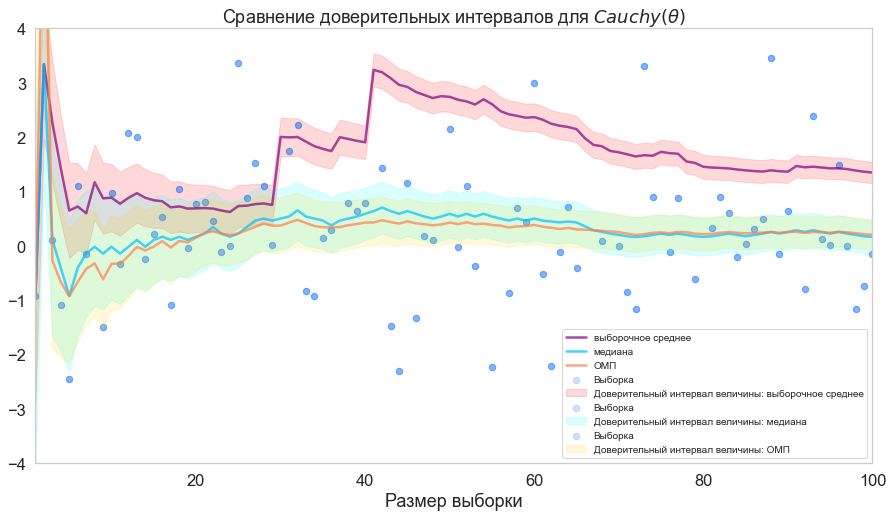

In [483]:
plt.figure(figsize=(15, 8))

draw_confidence_interval(lefts[0], righs[0], estimation=estimations[0], sample=X, ylim=(-4, 4), 
                         label_estimation='выборочное среднее', color_estimation='purple', color_interval='red')
draw_confidence_interval(lefts[1], righs[1], estimation=estimations[1], sample=X, ylim=(-4, 4), 
                         label_estimation='медиана', color_estimation='deepskyblue', color_interval='aqua')
draw_confidence_interval(lefts[2], righs[2], estimation=estimations[2], sample=X, ylim=(-4, 4), 
                         label_estimation='ОМП', color_estimation='coral', color_interval='gold')
plt.title('Сравнение доверительных интервалов для $Cauchy(\\theta)$')
plt.xlabel('Размер выборки');

**Вывод:**
*Оценки и доверительные интервалы, построенные 2 и 3 способом, сильно совпадают, в то время как точный доверительный интервал по параметрической модели сильно отличается на большой части выборки. Это объясняется тем, что распределение Коши не имеет матожидания.*

*Также видим, что доверительные интервалы широкие при малом размере выборки и сужаются с ростом выборки. Это объясняется тем, что они строятся для асимптотически эффективной оценки.*

_____________
## Задача 5.
На сегодняшний день возобновляемые источники энергии становятся все более востребованными. К таким источникам относятся, например, ветрогенераторы. Однако их мощность очень трудно прогнозировать. В частности, выработка энергии при помощи ветрогенератора сильно зависит от скорости ветра. Поэтому предсказание скорости ветра является очень важной задачей. Скорость ветра часто моделируют с помощью распределения Вейбулла, которое имеет плотность:
$$p_\theta(x) = \frac{kx^{k-1}}{\lambda^k} e^{-(x/\lambda)^k} I \{x \geq 0\},$$
где $\theta = (k, \lambda)$ &mdash; двумерный параметр. К сожалению, найти точную оценку максимального правдоподобия на $\theta$ не получится.  В данном задании нужно найти оценку максимального правдоподобия приближенно с помощью поиска по сетке.

За распределение Вейбулла отвечает класс `weibull_min` из модуля `scipy.stats`, которое задается так: `weibull_min(c=`$k$ `, scale=`$\lambda$ `)`.

**Выборка:** Создайте выборку по значеням среднесуточной скорости ветра на некоторой местности для нескольких лет (не менее трех). Данные дотупны на вики. Можно выбрать любой файл.

*a).* Найдите оценку максимального правдоподобия параметра $\theta = (k, \lambda)$ с точностью $10^{-5}$ при помощи поиска по двумерной сетке.

Двумерную сетку можно создать с помощью функции `numpy.mgrid[from:to:step, from:to:step]`. Если попробовать сразу создать сетку с шагом $10^{-5},$ то может не хватить памяти. Поэтому найдите сначала максимум по сетке с большим шагом, затем сделайте сетку с маленьким шагом в окрестности найденной точки. При вычислении без циклов, возможно, придется создавать трехмерные объекты.

Функция `numpy.argmax` выдает не очень информативный индекс, поэтому пользуйтесь следующей функцией.

In [27]:
def cool_argmax(array):
    return np.unravel_index(np.argmax(array), array.shape)

Нарисуйте график плотности с параметрами, соответствующим найденным ОМП, а так же нанесите на график гистограмму.

**Решение:**

*Оставим непустые данные за последние 10 лет*

In [28]:
data_wind = pd.read_csv('2.csv')
data_wind.dropna(inplace=True)
data_wind = data_wind[data_wind.Year > 2005]

In [29]:
data_wind_mean = data_wind.Mean

In [105]:
def max_likelihood(sample, distributions):
    """
    Ищет максимум функции правдоподобия распределения по заданной выборке
    :sample выборка
    :distribution распределение
    """
    pdf = distributions.logpdf(sample)
    likelihood = pdf.sum(axis=-1)

    return cool_argmax(likelihood)

def get_weibull_mle(sample, k, lambda_):
    """
    Ищет ОМП распределения Вейбулла по заданной выборке
    :sample выборка
    :k значения параметра k
    :lambda_ значения параметра lambda
    """
    # генерируем функции распределения Вейбулла в каждой точке сетки параметров
    distributions = sps.weibull_min(c=k.reshape((-1, 1, 1)), scale=lambda_.reshape((1, -1, 1)))
    
    # вычисляем MLE по выборке для каждого распределения
    argmax = max_likelihood(sample, distributions)
    
    # возвращаем лучшую оценку
    return [k[argmax[0]], lambda_[argmax[1]]]

In [109]:
prec = 1e-5
klims = [1e-3, 10]
lambda_lims = [1e-3, 10]

grid_scale = 1.0
k, lambda_ = 0, 0

while grid_scale > prec:
    # каждый раз генерим сетку параметров 10*10
    grid = np.mgrid[klims[0]:klims[1]+1:10j, lambda_lims[0]:lambda_lims[1]+1:10j]
    ks = grid[0].ravel()
    lambdas = grid[1].ravel()
    
    # находим оптимальные значения k и lambda
    k, lambda_ = get_weibull_mle(data_wind_mean, ks, lambdas)
    
    # сужаем интервалы параметров
    klims = [max(0, k - grid_scale), k + grid_scale]
    lambda_lims = [max(0, lambda_ - grid_scale), lambda_ + grid_scale]
    
    # уменьшаем масштаб сетки
    grid_scale /= 2

In [110]:
print(f'ОМП k: {round(k, 2)}')
print(f'ОМП lambda: {round(lambda_, 2)}')

ОМП k: 2.88
ОМП lambda: 5.57


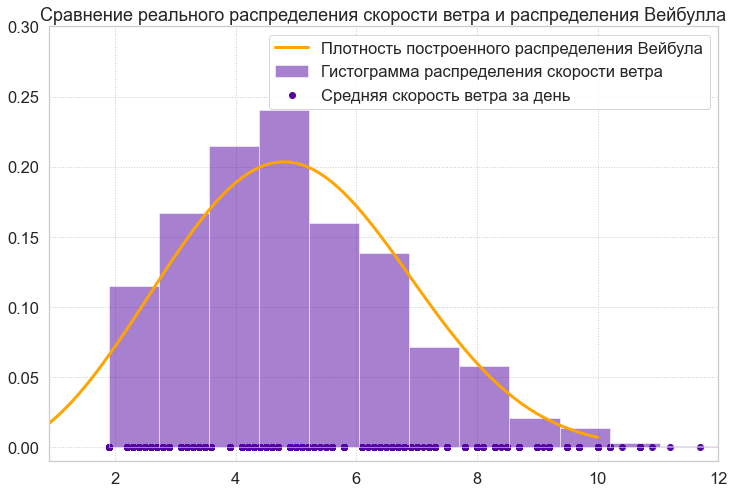

In [166]:
grid = np.linspace(0.1, 10, 100)
pdf = sps.weibull_min(c=k, scale=lambda_).pdf(grid)

plt.figure(figsize=(12, 8))

plt.scatter(data_wind_mean, np.zeros(data_wind_mean.shape[0]), label='Средняя скорость ветра за день')
plt.hist(data_wind_mean, density=True, bins=20, alpha=0.5, label='Гистограмма распределения скорости ветра')
plt.plot(grid, pdf, c='orange', lw=3, label='Плотность построенного распределения Вейбула')

plt.legend()
plt.xlim(0.9, 12)
plt.ylim(-0.01, .3)
plt.title('Сравнение реального распределения скорости ветра и распределения Вейбулла')
plt.grid()
plt.grid(ls=':');

*Видим, что полученные ОМП параметров дают распределение, которое довольно неплохо описывает реальные данные. Значит, на опыте подтвердили гипотезу о том, что скорости ветра описывается распределением Вейбулла.*

*b).* Обозначим $\widehat{\theta} = \left(\widehat{\lambda}, \widehat{k}\right)$ &mdash; ОМП. Запишите уравнение правдоподобия, приравняв все частные производные в точке экстремума логарифмической функции правдоподобия к $0$. Используя одно из равенств, можно выразить $\widehat{\lambda}$ через значения $X_1, \dots, X_n, \widehat{k}$; подставив это выражение в другое равенство, получить уравнение на $\widehat{k}$. Решите это уравнение приближенно с помощью метода Ньютона и получите $\widehat{k}$, а значит, и $\widehat{\lambda}$.

**Решение:**

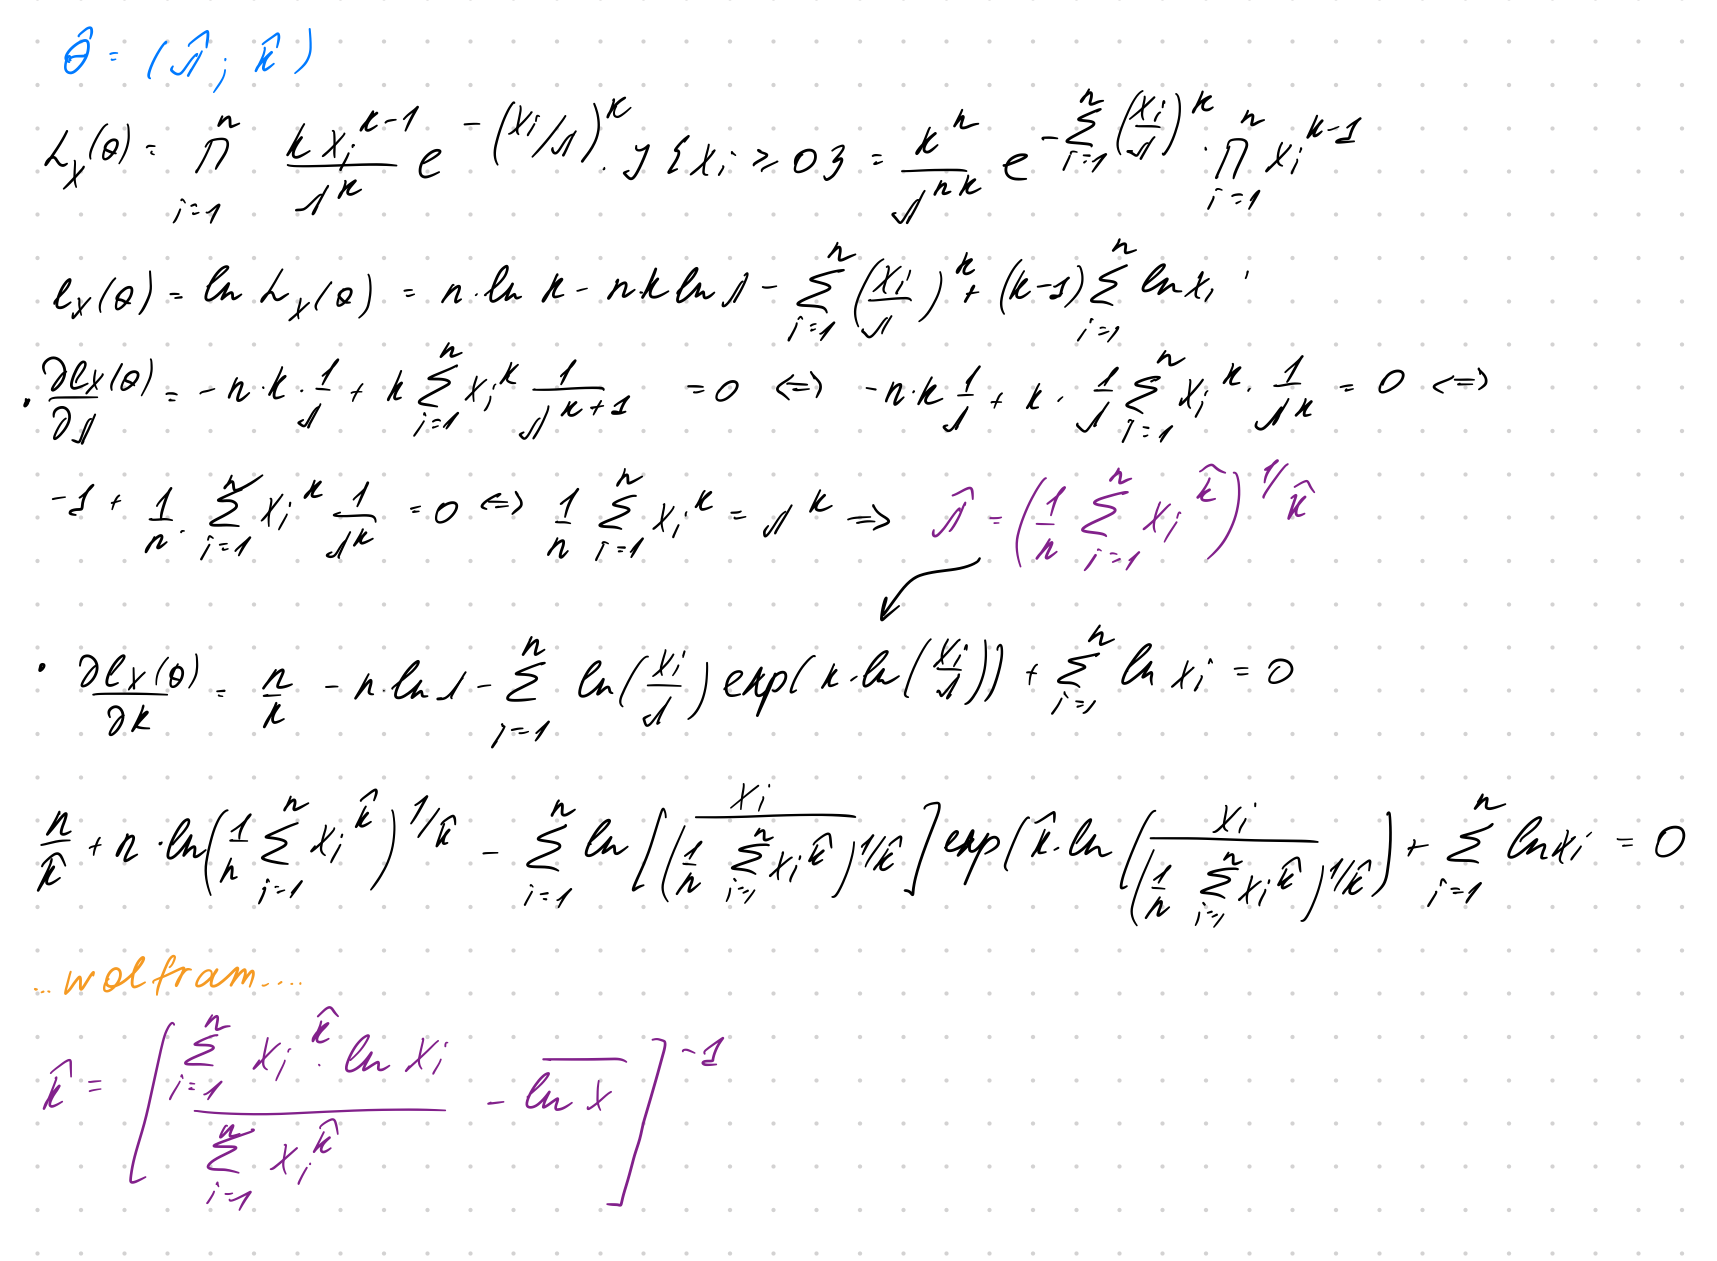

**Вывод:** *Получить ОМП распределения Вейбулла можно только численными методами, то есть например градиентными методами как метод Ньютона*